## The Density Based Spatial Clustering for Applications (DBSCAN) with Noise Benchmark

In [1]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
%matplotlib inline

from time import time

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, Normalizer
from sklearn.model_selection import RandomizedSearchCV

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event



from scipy import spatial

In [2]:
path_to_train = "E:\\train_1"

In [3]:
event_prefix = "event000001000"

In [4]:
hits, cells, particles, truth = load_event(os.path.join(path_to_train, event_prefix))

In [5]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1
4,5,-62.673599,-9.371200,-1502.5,7,2,1


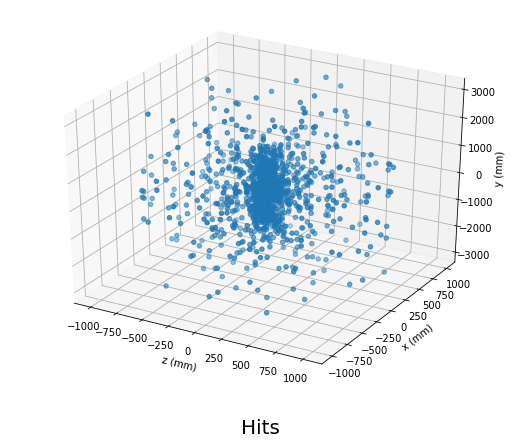

In [6]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(122,projection='3d')

x = hits['x']
x1 = x[::100]
y = hits['y']
y1 = y[::100]
z = hits['z']
z1 = z[::100]

ax.scatter(x1,y1,z1)

ax.set_xlabel('z (mm)')
ax.set_ylabel('x (mm)')
ax.set_zlabel('y (mm)')
ax.set_title("Hits", y=-.15, size=20)

plt.show()

In [7]:
cells.head()

,hit_id,ch0,ch1,value
0,1,209,617,0.013832
1,1,210,617,0.079887
2,1,209,618,0.211723
3,2,68,446,0.334087
4,3,58,954,0.034005


In [8]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824902,1,3


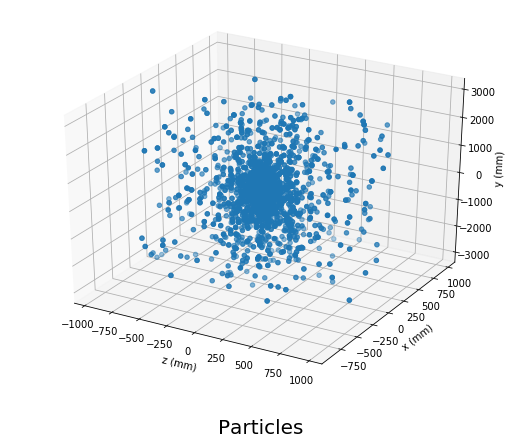

In [9]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(122,projection='3d')

x = particles['vx']
x1 = x[::10]
y = particles['vy']
y1 = y[::10]
z = particles['vz']
z1 = z[::10]

ax.scatter(x,y,z)

ax.set_xlabel('z (mm)')
ax.set_ylabel('x (mm)')
ax.set_zlabel('y (mm)')
ax.set_title("Particles", y=-.15, size=20)

plt.show()

In [10]:
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


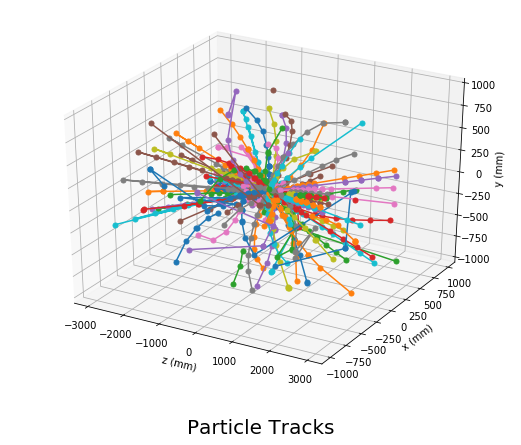

In [11]:
#Plot from Joshua Bonatt
tracks = truth.particle_id.unique()[1::100]
fig = plt.figure(figsize=(20,7))

ax2 = fig.add_subplot(122,projection='3d')
for track in tracks:
    hit_ids = truth[truth['particle_id'] == track]['hit_id']
    t = hits[hits['hit_id'].isin(hit_ids)][['x', 'y', 'z']]
    ax2.plot3D(t.z, t.x, t.y, '.-', ms=10)
    
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('x (mm)')
ax2.set_zlabel('y (mm)')
ax2.set_title("Particle Tracks", y=-.15, size=20)

plt.show()

In [12]:
#Based off of code from Mikhail Hushchyn
# Uses DBSCAN clustering algo
class Clusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

        r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        
        clf = DBSCAN(eps=self.eps, min_samples=1, algorithm='auto', n_jobs=-1)
        labels = clf.fit_predict(X)
        
        return labels

In [13]:
model = Clusterer(eps=0.00738)
labels = model.predict(hits)

In [14]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

In [15]:
submission = create_one_event_submission(0, hits, labels)

In [16]:
#Alternative scoring function from CPMP
def score_event_fast(truth, submission):
    truth = truth[['hit_id', 'particle_id', 'weight']].merge(submission, how='left', on='hit_id')
    df = truth.groupby(['track_id', 'particle_id']).hit_id.count().to_frame('count_both').reset_index()
    truth = truth.merge(df, how='left', on=['track_id', 'particle_id'])
    
    df1 = df.groupby(['particle_id']).count_both.sum().to_frame('count_particle').reset_index()
    truth = truth.merge(df1, how='left', on='particle_id')
    df1 = df.groupby(['track_id']).count_both.sum().to_frame('count_track').reset_index()
    truth = truth.merge(df1, how='left', on='track_id')
    truth.count_both *= 2
    score = truth[(truth.count_both > truth.count_particle) & (truth.count_both > truth.count_track)].weight.sum()
    return score

In [17]:
score = score_event_fast(truth, submission)
print("Your score: ", score)

Your score:  0.20306711


In [ ]:
dataset_submissions = []
dataset_scores = []
i = 0

for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=0, nevents=100):
    i+=1    
    # Track pattern recognition
    model = Clusterer(eps=0.008)
    labels = model.predict(hits)
        
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, hits, labels)
    dataset_submissions.append(one_submission)
    
    # Score for the event
    score = score_event_fast(truth, one_submission)
    dataset_scores.append(score)
    
print('Mean score: %.3f' % (np.mean(dataset_scores)))

## The Neural Network Approach

In [2]:
from tqdm import tqdm_notebook

prefix='E:\\'

def get_event(event):
    hits= pd.read_csv(prefix+'train_1/%s-hits.csv'%event)
    cells= pd.read_csv(prefix+'train_1/%s-cells.csv'%event)
    truth= pd.read_csv(prefix+'train_1/%s-truth.csv'%event)
    particles= pd.read_csv(prefix+'train_1/%s-particles.csv'%event)


In [3]:
# Adapted from outrunner-kaggle    return hits, cells, truth, particles
Train = []
for i in tqdm_notebook(range(10,20)):
    event = 'event0000010%02d'%i
    hits, cells, truth, particles = get_event(event)
    hit_cells = cells.groupby(['hit_id']).value.count().values
    hit_value = cells.groupby(['hit_id']).value.sum().values
    features = np.hstack((hits[['x','y','z']]/1000, hit_cells.reshape(len(hit_cells),1)/10,hit_value.reshape(len(hit_cells),1)))
    particle_ids = truth.particle_id.unique()
    particle_ids = particle_ids[np.where(particle_ids!=0)[0]]

    pair = []
    for particle_id in particle_ids:
        hit_ids = truth[truth.particle_id == particle_id].hit_id.values-1
        for i in hit_ids:
            for j in hit_ids:
                if i != j:
                    pair.append([i,j])
    pair = np.array(pair)   
    Train1 = np.hstack((features[pair[:,0]], features[pair[:,1]], np.ones((len(pair),1))))

    if len(Train) == 0:
        Train = Train1
    else:
        Train = np.vstack((Train,Train1))

    n = len(hits)
    size = len(Train1)*3
    p_id = truth.particle_id.values
    i =np.random.randint(n, size=size)
    j =np.random.randint(n, size=size)
    pair = np.hstack((i.reshape(size,1),j.reshape(size,1)))
    pair = pair[((p_id[i]==0) | (p_id[i]!=p_id[j]))]

    Train0 = np.hstack((features[pair[:,0]], features[pair[:,1]], np.zeros((len(pair),1))))

    print(event, Train1.shape)

    Train = np.vstack((Train,Train0))


np.random.shuffle(Train)
print(Train.shape)

event000001010 (905342, 11)
event000001011 (1049940, 11)
event000001012 (975962, 11)
event000001013 (937140, 11)
event000001014 (1138386, 11)
event000001015 (1096946, 11)
event000001016 (1054472, 11)
event000001017 (1125976, 11)
event000001018 (787588, 11)
event000001019 (1099946, 11)

(40684119, 11)


In [7]:
import pandas as pd
df = pd.DataFrame(Train)
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.031143,-0.007685,0.000165,0.3,0.307577,0.120749,0.344592,0.201000,0.3,3.000000,0.0
1,0.307593,0.190076,-0.335400,0.4,4.000000,0.067226,-0.026196,-1.098000,0.2,0.277347,0.0
2,1.012740,-0.140985,0.254600,0.4,4.000000,0.062592,-0.035696,0.022835,0.4,0.334701,1.0
3,0.259274,0.256592,0.176600,0.2,2.000000,0.325745,-0.967520,0.715600,0.4,4.000000,0.0
4,0.216825,0.448875,0.785720,0.5,5.000000,-0.039330,-0.059234,0.033791,0.4,0.295426,0.0


In [69]:
from keras import Sequential 
from keras.layers import Dense
from keras import optimizers
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU

In [85]:
fs = 10

model = Sequential()
model.add(Dense(1024, activation='linear', input_shape=(fs,)))
model.add(LeakyReLU(alpha=.001))
model.add(Dense(512, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dense(256, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dense(32, activation='linear'))
model.add(LeakyReLU(alpha=.001))

model.add(Dense(1, activation='sigmoid'))

epochs=30
lrate=0.001
model.compile(loss=['binary_crossentropy'], optimizer=Adam(lr=lrate), metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 1024)              11264     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_115 (Dense)            (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 128)               32896     
__________

In [86]:
model.fit(x=Train[:,:-1], y=Train[:,-1], batch_size=8000, epochs=epochs, verbose=2, validation_split=0.05, shuffle=True)

print("done")

Train on 38649985 samples, validate on 2034210 samples
Epoch 1/30
 - 74s - loss: 0.0763 - acc: 0.9721 - val_loss: 0.0446 - val_acc: 0.9855
Epoch 2/30
 - 74s - loss: 0.0406 - acc: 0.9868 - val_loss: 0.0368 - val_acc: 0.9881
Epoch 3/30
 - 73s - loss: 0.0357 - acc: 0.9884 - val_loss: 0.0336 - val_acc: 0.9891
Epoch 4/30
 - 73s - loss: 0.0331 - acc: 0.9892 - val_loss: 0.0316 - val_acc: 0.9898
Epoch 5/30
 - 73s - loss: 0.0313 - acc: 0.9898 - val_loss: 0.0320 - val_acc: 0.9897
Epoch 6/30
 - 73s - loss: 0.0300 - acc: 0.9902 - val_loss: 0.0303 - val_acc: 0.9902
Epoch 7/30
 - 74s - loss: 0.0290 - acc: 0.9905 - val_loss: 0.0295 - val_acc: 0.9904
Epoch 8/30
 - 74s - loss: 0.0282 - acc: 0.9907 - val_loss: 0.0286 - val_acc: 0.9907
Epoch 9/30
 - 74s - loss: 0.0275 - acc: 0.9910 - val_loss: 0.0282 - val_acc: 0.9908
Epoch 10/30
 - 73s - loss: 0.0269 - acc: 0.9911 - val_loss: 0.0290 - val_acc: 0.9905
Epoch 11/30
 - 73s - loss: 0.0264 - acc: 0.9913 - val_loss: 0.0268 - val_acc: 0.9912
Epoch 12/30
 - 73s 

In [ ]:
# Adapted from outrunner-kaggle
TestX = np.zeros((len(features), 10))
TestX[:,5:] = features

TestX1 = np.zeros((len(features), 10))
TestX1[:,:5] = features

preds = []

for i in tqdm_notebook(range(len(features)-1)):
    TestX[i+1:,:5] = np.tile(features[i], (len(TestX)-i-1, 1))

    pred = model.predict(TestX[i+1:], batch_size=20000)[:,0]                
    idx = np.where(pred>0.2)[0]

    if len(idx) > 0:
        TestX1[idx+i+1,5:] = TestX[idx+i+1,:5]
        pred1 = model.predict(TestX1[idx+i+1], batch_size=20000)[:,0]
        pred[idx] = (pred[idx]+pred1)/2

    idx = np.where(pred>0.5)[0]

    preds.append([idx+i+1, pred[idx]])


preds.append([np.array([], dtype='int64'), np.array([], dtype='float32')])

# rebuild to NxN
for i in range(len(preds)):
    ii = len(preds)-i-1
    for j in range(len(preds[ii][0])):
        jj = preds[ii][0][j]
        preds[jj][0] = np.insert(preds[jj][0], 0 ,ii)
        preds[jj][1] = np.insert(preds[jj][1], 0 ,preds[ii][1][j])

    np.save('my_%s.npy'%event, preds)

In [ ]:
# Adapted from outrunner-kaggle
def get_path2(hit, mask, thr):
    path = [hit]
    a = 0
    while True:
        c = get_predict2(path[-1])
        mask = (c > thr)*mask
        mask[path[-1]] = 0
        
        if 1:
            cand = np.where(c>thr)[0]
            if len(cand)>0:
                mask[cand[np.isin(module_id[cand], module_id[path])]]=0
                
        a = (c + a)*mask
        if a.max() < thr*len(path):
            break
        path.append(a.argmax())
    return path

def get_predict2(p):
    c = np.zeros(len(preds))
    c[preds[p, 0]] = preds[p, 1]          
    return c

In [ ]:
# Adapted from outrunner-kaggle
tracks_all = []
thr = 0.85
x4 = True
for hit in tqdm_notebook(range(len(preds))):
    m = np.ones(len(truth))
    path  = get_path2(hit, m, thr)
    if x4 and len(path) > 1:
        m[path[1]]=0
        path2  = get_path2(hit, m, thr)
        if len(path) < len(path2):
            path = path2
            m[path[1]]=0
            path2  = get_path2(hit, m, thr)
            if len(path) < len(path2):
                path = path2
        elif len(path2) > 1:
            m[path[1]]=1
            m[path2[1]]=0
            path2  = get_path2(hit, m, thr)
            if len(path) < len(path2):
                path = path2
    tracks_all.append(path)
np.save('my_tracks_all', tracks_all)

In [ ]:
#Alternative scoring function from CPMP
def score_event_fast(truth, submission):
    truth = truth[['hit_id', 'particle_id', 'weight']].merge(submission, how='left', on='hit_id')
    df = truth.groupby(['track_id', 'particle_id']).hit_id.count().to_frame('count_both').reset_index()
    truth = truth.merge(df, how='left', on=['track_id', 'particle_id'])
    
    df1 = df.groupby(['particle_id']).count_both.sum().to_frame('count_particle').reset_index()
    truth = truth.merge(df1, how='left', on='particle_id')
    df1 = df.groupby(['track_id']).count_both.sum().to_frame('count_track').reset_index()
    truth = truth.merge(df1, how='left', on='track_id')
    truth.count_both *= 2
    score = truth[(truth.count_both > truth.count_particle) & (truth.count_both > truth.count_track)].weight.sum()
    return score

In [ ]:
scores = get_track_score(tracks_all, 8)

In [ ]:
idx = np.argsort(scores)[::-1]
tracks = np.zeros(len(hits))
track_id = 0

for hit in idx:

    path = np.array(tracks_all[hit])
    path = path[np.where(tracks[path]==0)[0]]

    if len(path)>3:
        track_id = track_id + 1  
        tracks[path] = track_id

In [ ]:
submission = pd.DataFrame({'hit_id': truth.hit_id, 'track_id': tracks})

In [ ]:
score = score_event_fast(truth, submission)[

print(score)